<a href="https://colab.research.google.com/github/aditya161205/NLP/blob/main/BERT_scratch_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###There are two steps in our framework: pre-training and fine-tuning.

During pre-training, the model is trained on unlabeled data over different pre-training tasks. For fine- tuning, the BERT model is first initialized with the pre-trained parameters, and all of the parameters are fine-tuned using labeled data from the downstream tasks

We denote
**number of layers** as **L**

The **hidden size** as **H**

number of **self-attention heads** as **A**.

 We primarily report results on two model sizes: BERTBASE (L=12, H=768, A=12, Total Parameters=110M) and BERTLARGE (L=24, H=1024, A=16, Total Parameters=340M).



---



---
In this project we will use the following values

**L=4**

**H=256**

**A=4**

This makes the total parameters 20M


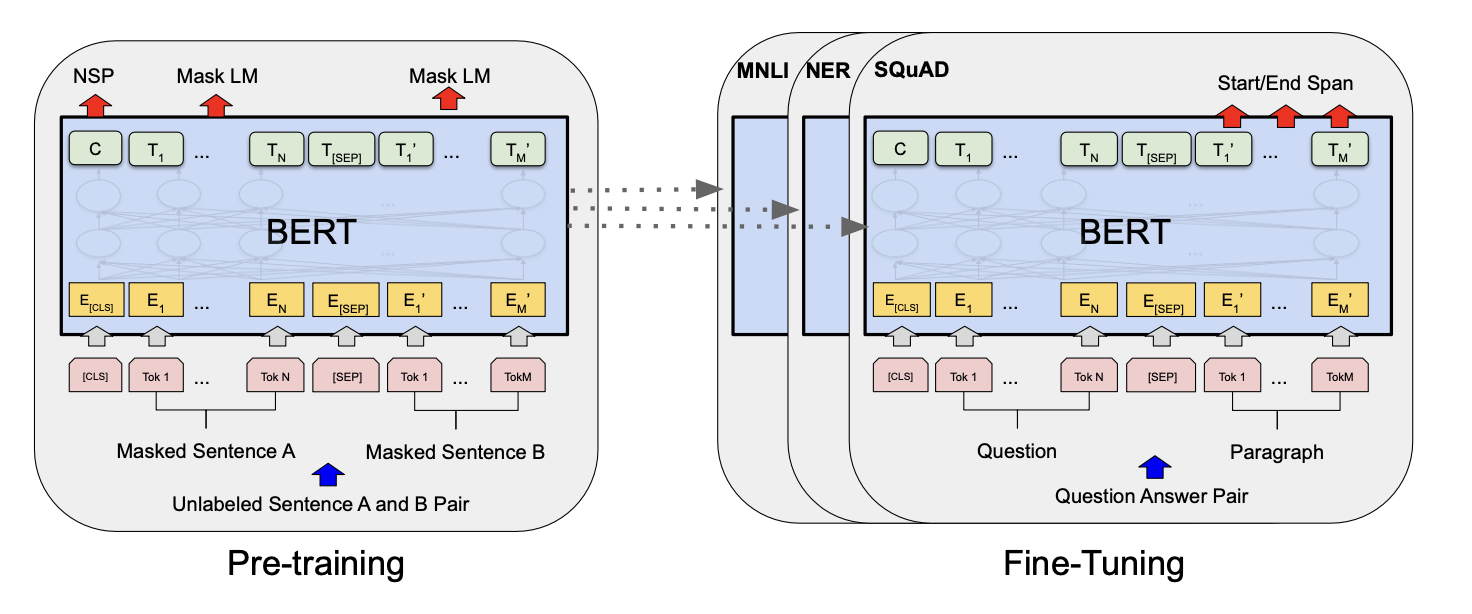

In [36]:
class Config:
    vocab_size = 30522
    hidden_size = 256
    num_hidden_layers = 4
    num_attention_heads = 4
    intermediate_size = 1024
    max_position_embeddings = 512
    type_vocab_size = 2
    hidden_dropout_prob = 0.1


In [2]:
import math
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import BertTokenizerFast

In [3]:
dataset = load_dataset("wikitext", "wikitext-2-v1")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### loaded the dataset successfully

In [4]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")


In [5]:
Config.vocab_size = tokenizer.vocab_size

### Implementing NSP



---



---



---



In [6]:
train_text=dataset["train"]["text"]
sentences = [s for s in train_text if isinstance(s, str) and len(s.strip()) > 1]

In [7]:
import random

In [8]:
def create_nsp_pairs(sentences, tokenizer,max_len=128):

  nsp_pairs=[]

  for i in range(len(sentences)-1):
    first=sentences[i]

    if random.random()<=0.5:
      second = sentences[i+1]
      label=1
    else:
      second = random.choice(sentences)
      label=0

    encod=tokenizer(first,second,truncation=True,max_length=max_len,padding='max_length',return_tensors='pt')
    nsp_pairs.append({
            "input_ids": encod["input_ids"],
            "token_type_ids": encod["token_type_ids"],
            "attention_mask": encod["attention_mask"],
            "nsp_label": label
        })
  return nsp_pairs



In [9]:
len(sentences)

23758

In [10]:
sentences[:5]

[' = Valkyria Chronicles III = \n',
 ' Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . \n',
 " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more <unk> for series newcom

In [11]:
nsp = create_nsp_pairs(sentences, tokenizer, max_len=128)
len(nsp)

23757

### implementing MLM



---



---



---



In [12]:
tokenizer.SPECIAL_TOKENS_ATTRIBUTES

['bos_token',
 'eos_token',
 'unk_token',
 'sep_token',
 'pad_token',
 'cls_token',
 'mask_token',
 'additional_special_tokens']

In [13]:
vocab_size=tokenizer.vocab_size
vocab_size

30522

In [14]:
mask_id= tokenizer.mask_token_id
cls_id=tokenizer.cls_token_id
sep_id=tokenizer.sep_token_id
pad_id=tokenizer.pad_token_id

special={mask_id,cls_id,sep_id,pad_id}
special


{0, 101, 102, 103}

**If the i-th token is chosen, we replace the i-th token with (1) the [MASK] token 80% of the time (2) a random token 10% of the time (3) the unchanged i-th token 10% of the time.**

In [15]:
def mlm(input_ids, tokenizer, prob=0.15):
    input_ids = input_ids.clone()
    labels = input_ids.clone()

    mask_id = tokenizer.mask_token_id
    cls_id = tokenizer.cls_token_id
    sep_id = tokenizer.sep_token_id
    pad_id = tokenizer.pad_token_id

    special = {cls_id, sep_id, pad_id, mask_id}

    candidate_positions = [
        i for i, tok in enumerate(input_ids.tolist())
        if tok not in special
    ]

    if len(candidate_positions) == 0:
        return input_ids, torch.full_like(labels, -100)

    num_to_mask = int(len(candidate_positions) * prob)
    num_to_mask = max(1, num_to_mask)
    num_to_mask = min(num_to_mask, len(candidate_positions))

    mask_positions = random.sample(candidate_positions, num_to_mask)

    # Create a list of non-special token IDs
    non_special_token_ids = [i for i in range(tokenizer.vocab_size) if i not in special]

    for pos in mask_positions:
        r = random.random()
        if r < 0.8:
            input_ids[pos] = mask_id
        elif r < 0.9:
            # Choose a random token ID from the non-special token IDs
            input_ids[pos] = random.choice(non_special_token_ids)
        else:
            pass

    for i in range(len(labels)):
        if i not in mask_positions:
            labels[i] = -100

    return input_ids, labels

**In the last section of above written code, we gave the label -100 value if the token is not masked. This is done because the Bert research paper says that**

*The model is trained to predict the original vocabulary id of the masked word based only on its context.*
*Then, Ti will be used to predict the original token with cross entropy loss*

And as a convention in crossentropy, if the value is -100, these are ignored while loss calculation



---



---



---



Now we crewate the dataset class and data loader, the following code is sourced from medium

In [16]:
class BertDataset(Dataset):
    def __init__(self, nsp_data, tokenizer):
        self.data = []
        self.tokenizer = tokenizer

        for sample in nsp_data:
            input_ids = sample["input_ids"].squeeze()
            token_type_ids = sample["token_type_ids"].squeeze()
            attention_mask = sample["attention_mask"].squeeze()
            nsp_label = sample["nsp_label"]

            masked_ids, mlm_labels = mlm(input_ids, tokenizer)

            self.data.append({
                "input_ids": masked_ids,
                "token_type_ids": token_type_ids,
                "attention_mask": attention_mask,
                "mlm_labels": mlm_labels,
                "nsp_label": torch.tensor(nsp_label, dtype=torch.long)
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [17]:
batch_size = 32
dataset_obj = BertDataset(nsp, tokenizer)
train_loader = DataLoader(dataset_obj, batch_size=batch_size, shuffle=True)
print("Total training samples:", len(dataset_obj))


Total training samples: 23757




---



---



---

### **Embeddings**

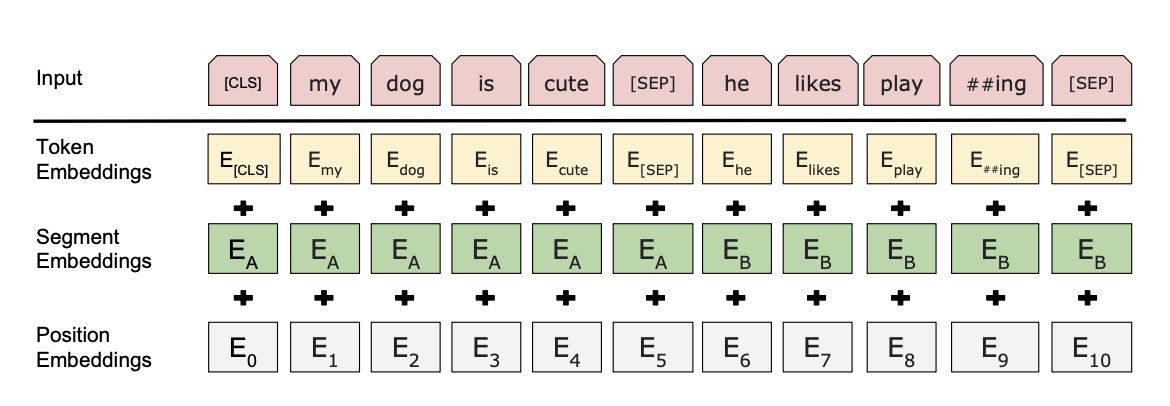

The embedding tables will loke like the following


---




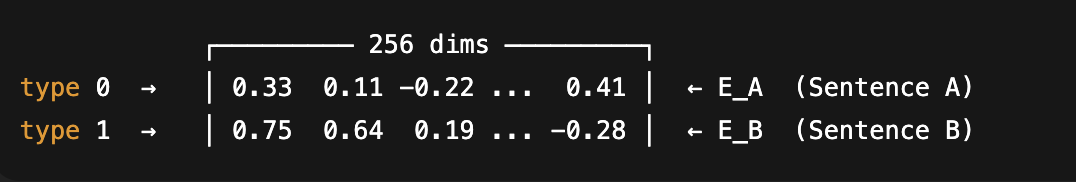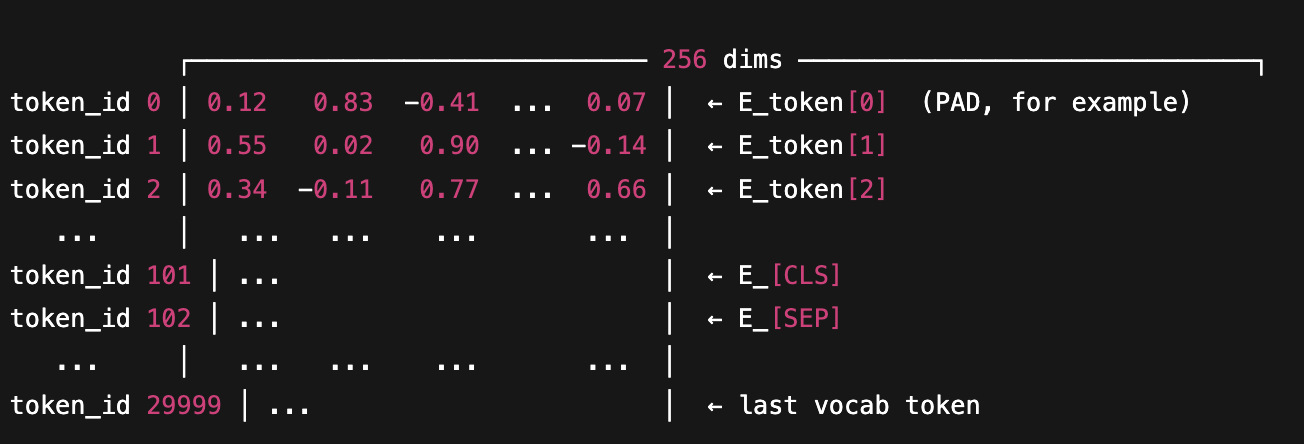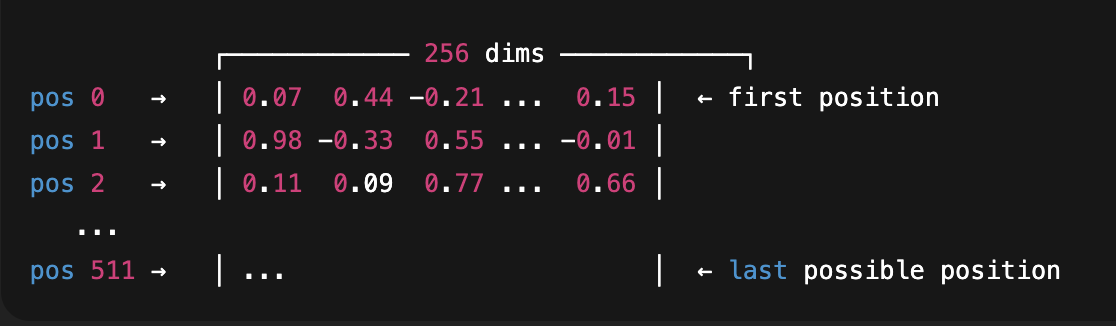

In [18]:

class Embeddings(nn.Module):
    def __init__(self, vocab_size=30000, hidden_size=256, max_position_embeddings=512, type_vocab_size=2, dropout=0.1):
        super().__init__()
        # E_token
        self.word_embeddings = nn.Embedding(vocab_size, hidden_size)
        # E_pos
        self.position_embeddings = nn.Embedding(max_position_embeddings, hidden_size)
        # E_segment (EA, EB)
        self.token_type_embeddings = nn.Embedding(type_vocab_size, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, token_type_ids):
        batch_size, seq_len = input_ids.size()
        token_embeddings = self.word_embeddings(input_ids) #token embedding lookup form the table

        pos_ids = torch.arange(seq_len, dtype=torch.long, device=input_ids.device)
        pos_ids = pos_ids.unsqueeze(0).expand(batch_size, seq_len)
        position_embeddings = self.position_embeddings(pos_ids)
        segment_embeddings = self.token_type_embeddings(token_type_ids)  #segment embedding lookup form the table
        embeddings = token_embeddings + position_embeddings + segment_embeddings
        #final dimensions (B,L,H)
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings



---



---



---



**Multi-headed attention**

I already have the code for this in my own repo where I tried to implement transformer from scratch

*BERT uses the self-attention mechanism to unify these two stages, as encoding a concatenated text pair with self-attention effectively includes bidi- rectional cross attention between two sentences.*

In [19]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_mod, num_heads):
        super().__init__()
        self.d_mod = d_mod
        self.num_heads = num_heads
        self.d_k = d_mod // num_heads

        self.W_q = nn.Linear(d_mod, d_mod)
        self.W_k = nn.Linear(d_mod, d_mod)
        self.W_v = nn.Linear(d_mod, d_mod)

        self.W_o = nn.Linear(d_mod, d_mod)
        self.dropout = nn.Dropout(0.1)

    def ScaledDotProduct(self, Q, K, V, mask=None):
        attn = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(1).unsqueeze(2)  # (batch,1,1,seq)
            elif mask.dim() == 3:
                mask = mask.unsqueeze(1)  # (batch,1,seq,seq)
            attn = attn.masked_fill(mask == 0, float('-inf'))
        attn_prob = torch.softmax(attn, dim=-1)
        attn_prob = self.dropout(attn_prob)
        return torch.matmul(attn_prob, V)

    def split_heads(self, x):
        batch, seq_len, _ = x.size()
        return x.view(batch, seq_len, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch, _, seq_len, _ = x.size()
        return x.transpose(1, 2).contiguous().view(batch, seq_len, self.d_mod)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_val = self.ScaledDotProduct(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_val))

        return output


writing code for feed forward. But unlike most of the cases, it uses GeLU not ReLU.

This is because probabilistic nature of GeLU is thought to be a good fit for the attention mechanisms.

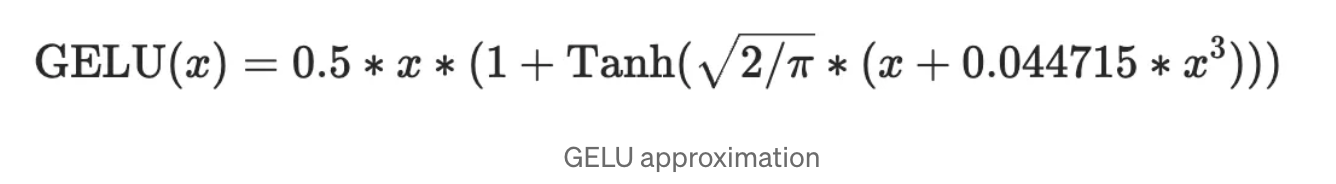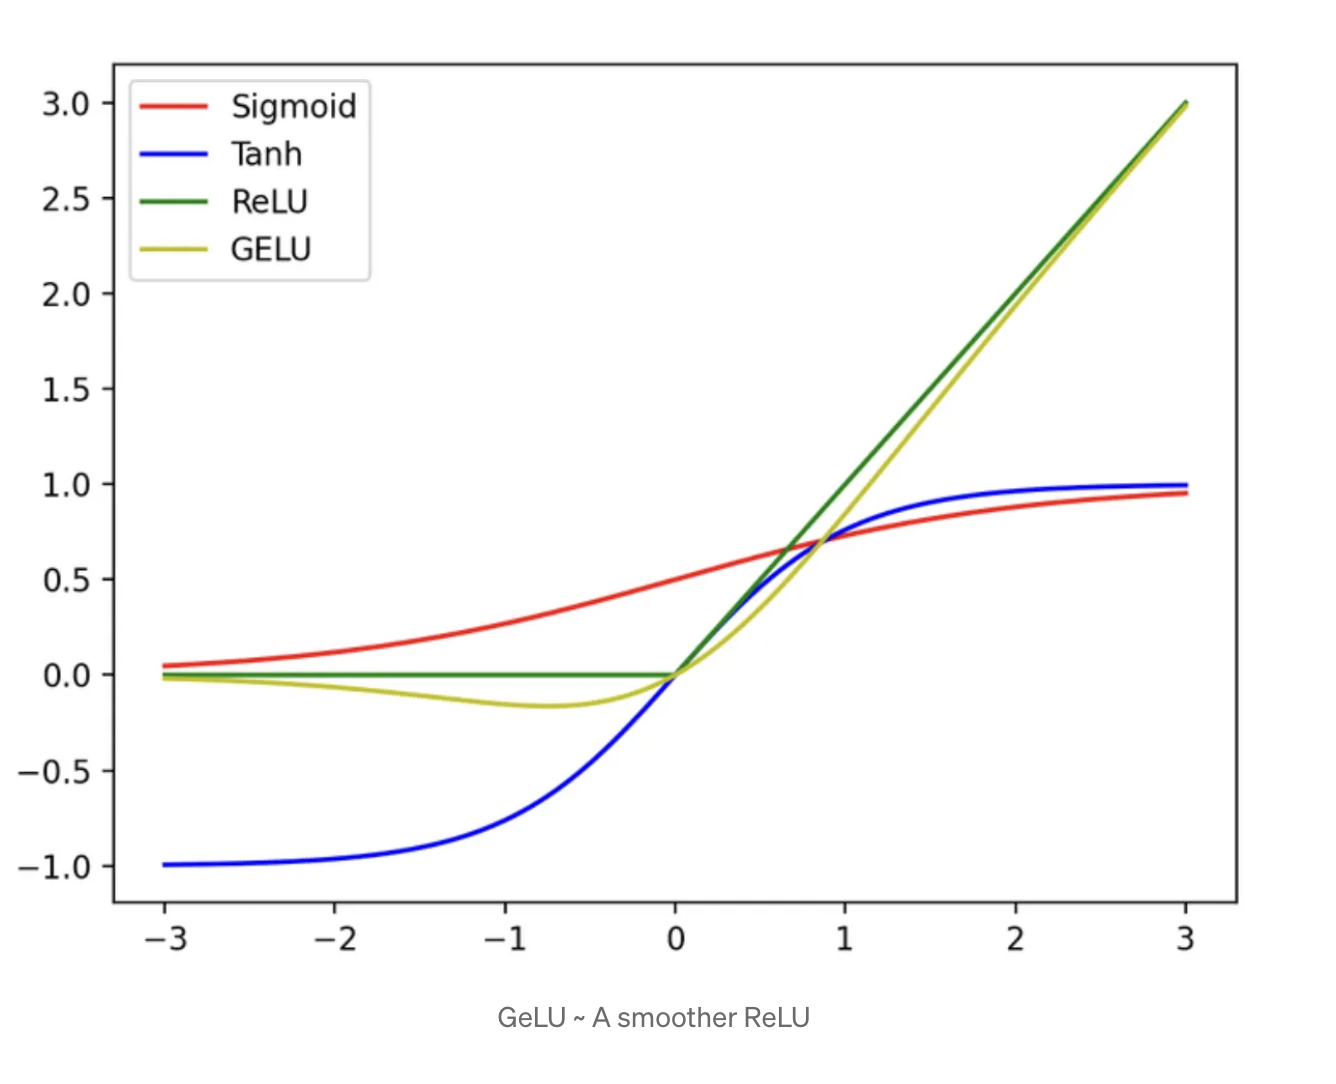

In [20]:
class FeedForward(nn.Module):
    def __init__(self, hidden_size=256, intermediate_size=1024, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(hidden_size, intermediate_size)
        self.activation = nn.GELU()
        self.linear2 = nn.Linear(intermediate_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x

### **coding a single ENCODER layer**

In [21]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_size=256, num_heads=4, intermediate_size=1024, dropout=0.1):
        super().__init__()
        #attention
        self.attention = MultiHeadAttention(hidden_size, num_heads)
        self.attn_layer_norm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.attn_dropout = nn.Dropout(dropout)
        #forward
        self.ff = FeedForward(hidden_size, intermediate_size, dropout)
        self.ff_layer_norm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.ff_dropout = nn.Dropout(dropout)

    def forward(self, x, attention_mask=None):
        attn_output = self.attention(x, x, x, attention_mask)
        x = x + self.attn_dropout(attn_output)
        x = self.attn_layer_norm(x)
        ff_output = self.ff(x)
        x = x + self.ff_dropout(ff_output)
        x = self.ff_layer_norm(x)
        return x

### lets stack the single encoder layers to make the full Bert Encoder

In [22]:
class BertEncoder(nn.Module):
    def __init__(self, num_layers=4, hidden_size=256, num_heads=4, intermediate_size=1024, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(hidden_size, num_heads, intermediate_size, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, attention_mask=None):
        for layer in self.layers:
            x = layer(x, attention_mask)
        return x



---



---



---

Let's make the pretraining head

In [23]:
class PreTrainingHeads(nn.Module):
    def __init__(self, hidden_size, vocab_size):
        super().__init__()
        self.mlm_head = nn.Linear(hidden_size, vocab_size)
        self.nsp_head = nn.Linear(hidden_size, 2)

    def forward(self, sequence_output, cls_output):
        mlm_logits = self.mlm_head(sequence_output)
        nsp_logits = self.nsp_head(cls_output)
        return mlm_logits, nsp_logits




---



---



---

## **Putting everything together**

**The BERT model**

In [24]:
class BertModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embeddings(
            vocab_size=config.vocab_size,
            hidden_size=config.hidden_size,
            max_position_embeddings=config.max_position_embeddings,
            type_vocab_size=config.type_vocab_size,
            dropout=config.hidden_dropout_prob
        )

        self.encoder = BertEncoder(
            num_layers=config.num_hidden_layers,
            hidden_size=config.hidden_size,
            num_heads=config.num_attention_heads,
            intermediate_size=config.intermediate_size,
            dropout=config.hidden_dropout_prob
        )

        self.heads = PreTrainingHeads(
            hidden_size=config.hidden_size,
            vocab_size=config.vocab_size
        )

    def forward(self, input_ids, token_type_ids, attention_mask):
        x = self.embeddings(input_ids, token_type_ids)
        encoded = self.encoder(x, attention_mask)
        cls_output = encoded[:, 0] # cls token -> 0
        mlm_logits, nsp_logits = self.heads(encoded, cls_output)
        return mlm_logits, nsp_logits


**Loss function**

sourcing the code from medium article

In [25]:
mlm_lf = nn.CrossEntropyLoss(ignore_index=-100)
nsp_lf = nn.CrossEntropyLoss()

def compute_loss(mlm_logits, nsp_logits, mlm_labels, nsp_labels):
    mlm_loss = mlm_lf(mlm_logits.view(-1, mlm_logits.size(-1)), mlm_labels.view(-1))
    nsp_loss = nsp_lf(nsp_logits, nsp_labels)
    return mlm_loss + nsp_loss, mlm_loss, nsp_loss




---


---



---



### **Training Loop**

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
Config.vocab_size

30522

In [28]:
tokenizer.vocab_size

30522

In [29]:
model = BertModel(Config()).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) #this is the standard optimizer used for BERT

In [30]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_mlm = 0.0
    total_nsp = 0.0
    correct_nsp = 0
    total_nsp_count = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        mlm_labels = batch["mlm_labels"].to(device)
        nsp_labels = batch["nsp_label"].to(device)

        mlm_logits, nsp_logits = model(input_ids, token_type_ids, attention_mask)

        loss, mlm_loss, nsp_loss = compute_loss(mlm_logits, nsp_logits, mlm_labels, nsp_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_mlm += mlm_loss.item()
        total_nsp += nsp_loss.item()

        preds = torch.argmax(nsp_logits, dim=1)
        correct_nsp += (preds == nsp_labels).sum().item()
        total_nsp_count += nsp_labels.size(0)

    avg_loss = total_loss / len(train_loader)
    avg_mlm = total_mlm / len(train_loader)
    avg_nsp = total_nsp / len(train_loader)
    nsp_acc = 100.0 * correct_nsp / total_nsp_count if total_nsp_count > 0 else 0.0

    print(f"Epoch {epoch+1}/{num_epochs} | loss={avg_loss:.4f} mlm={avg_mlm:.4f} nsp={avg_nsp:.4f} NSP_acc={nsp_acc:.2f}%")


Epoch 1/5 | loss=7.7690 mlm=7.0691 nsp=0.6999 NSP_acc=51.83%
Epoch 2/5 | loss=7.1795 mlm=6.5136 nsp=0.6659 NSP_acc=57.35%
Epoch 3/5 | loss=7.0514 mlm=6.4019 nsp=0.6495 NSP_acc=59.21%
Epoch 4/5 | loss=6.9537 mlm=6.3111 nsp=0.6426 NSP_acc=60.11%
Epoch 5/5 | loss=6.8514 mlm=6.2146 nsp=0.6368 NSP_acc=60.89%


Now we can start pretraining

In [31]:
batch = next(iter(train_loader))
with torch.no_grad():
    mlm_logits, nsp_logits = model(
        batch["input_ids"].to(device),
        batch["token_type_ids"].to(device),
        batch["attention_mask"].to(device)
    )
print("Forward pass shapes:", mlm_logits.shape, nsp_logits.shape)

Forward pass shapes: torch.Size([32, 128, 30522]) torch.Size([32, 2])


In [32]:
def predict_masked(text, tokenizer, model, top_k=5):
    model.eval()
    enc = tokenizer(text, return_tensors='pt', truncation=True, max_length=128, padding='max_length')
    input_ids = enc["input_ids"].to(device)
    token_type_ids = enc["token_type_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)

    with torch.no_grad():
        mlm_logits, _ = model(input_ids, token_type_ids, attention_mask)

    mask_index = (input_ids[0] == tokenizer.mask_token_id).nonzero(as_tuple=True)[0]
    if mask_index.numel() == 0:
        return []
    logits = mlm_logits[0, mask_index[0], :]
    probs = torch.softmax(logits, dim=-1)
    top_tokens = torch.topk(probs, top_k).indices.tolist()
    return [tokenizer.decode([t]) for t in top_tokens]



In [33]:
def predict_nsp(sentence_a, sentence_b, tokenizer, model):
    model.eval()
    enc = tokenizer(sentence_a, sentence_b, return_tensors='pt')
    with torch.no_grad():
        _, nsp_logits = model(
            enc["input_ids"].to(device),
            enc["token_type_ids"].to(device),
            enc["attention_mask"].to(device)
        )
    probs = torch.softmax(nsp_logits, dim=-1)
    return probs[0].tolist()  # [not_next, is_next]


In [34]:

print("Masked predictions example:", predict_masked("The capital of France is [MASK].", tokenizer, model))
print("NSP example probs (not_next, is_next):", predict_nsp("Paris is the capital of France.", "It is known for the Eiffel Tower.", tokenizer, model))



Masked predictions example: ['the', 'of', 'is', ',', 'in']
NSP example probs (not_next, is_next): [0.07777716964483261, 0.9222228527069092]


In [35]:
torch.save(model.state_dict(), "bert_scratch_final.pth")
print("Saved model: bert_scratch_final.pth")

Saved model: bert_scratch_final.pth
